C:\Users\User\AppData\Local\Temp\ipykernel_24592\1997657003.py:12: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("output_filtered_complete.csv")


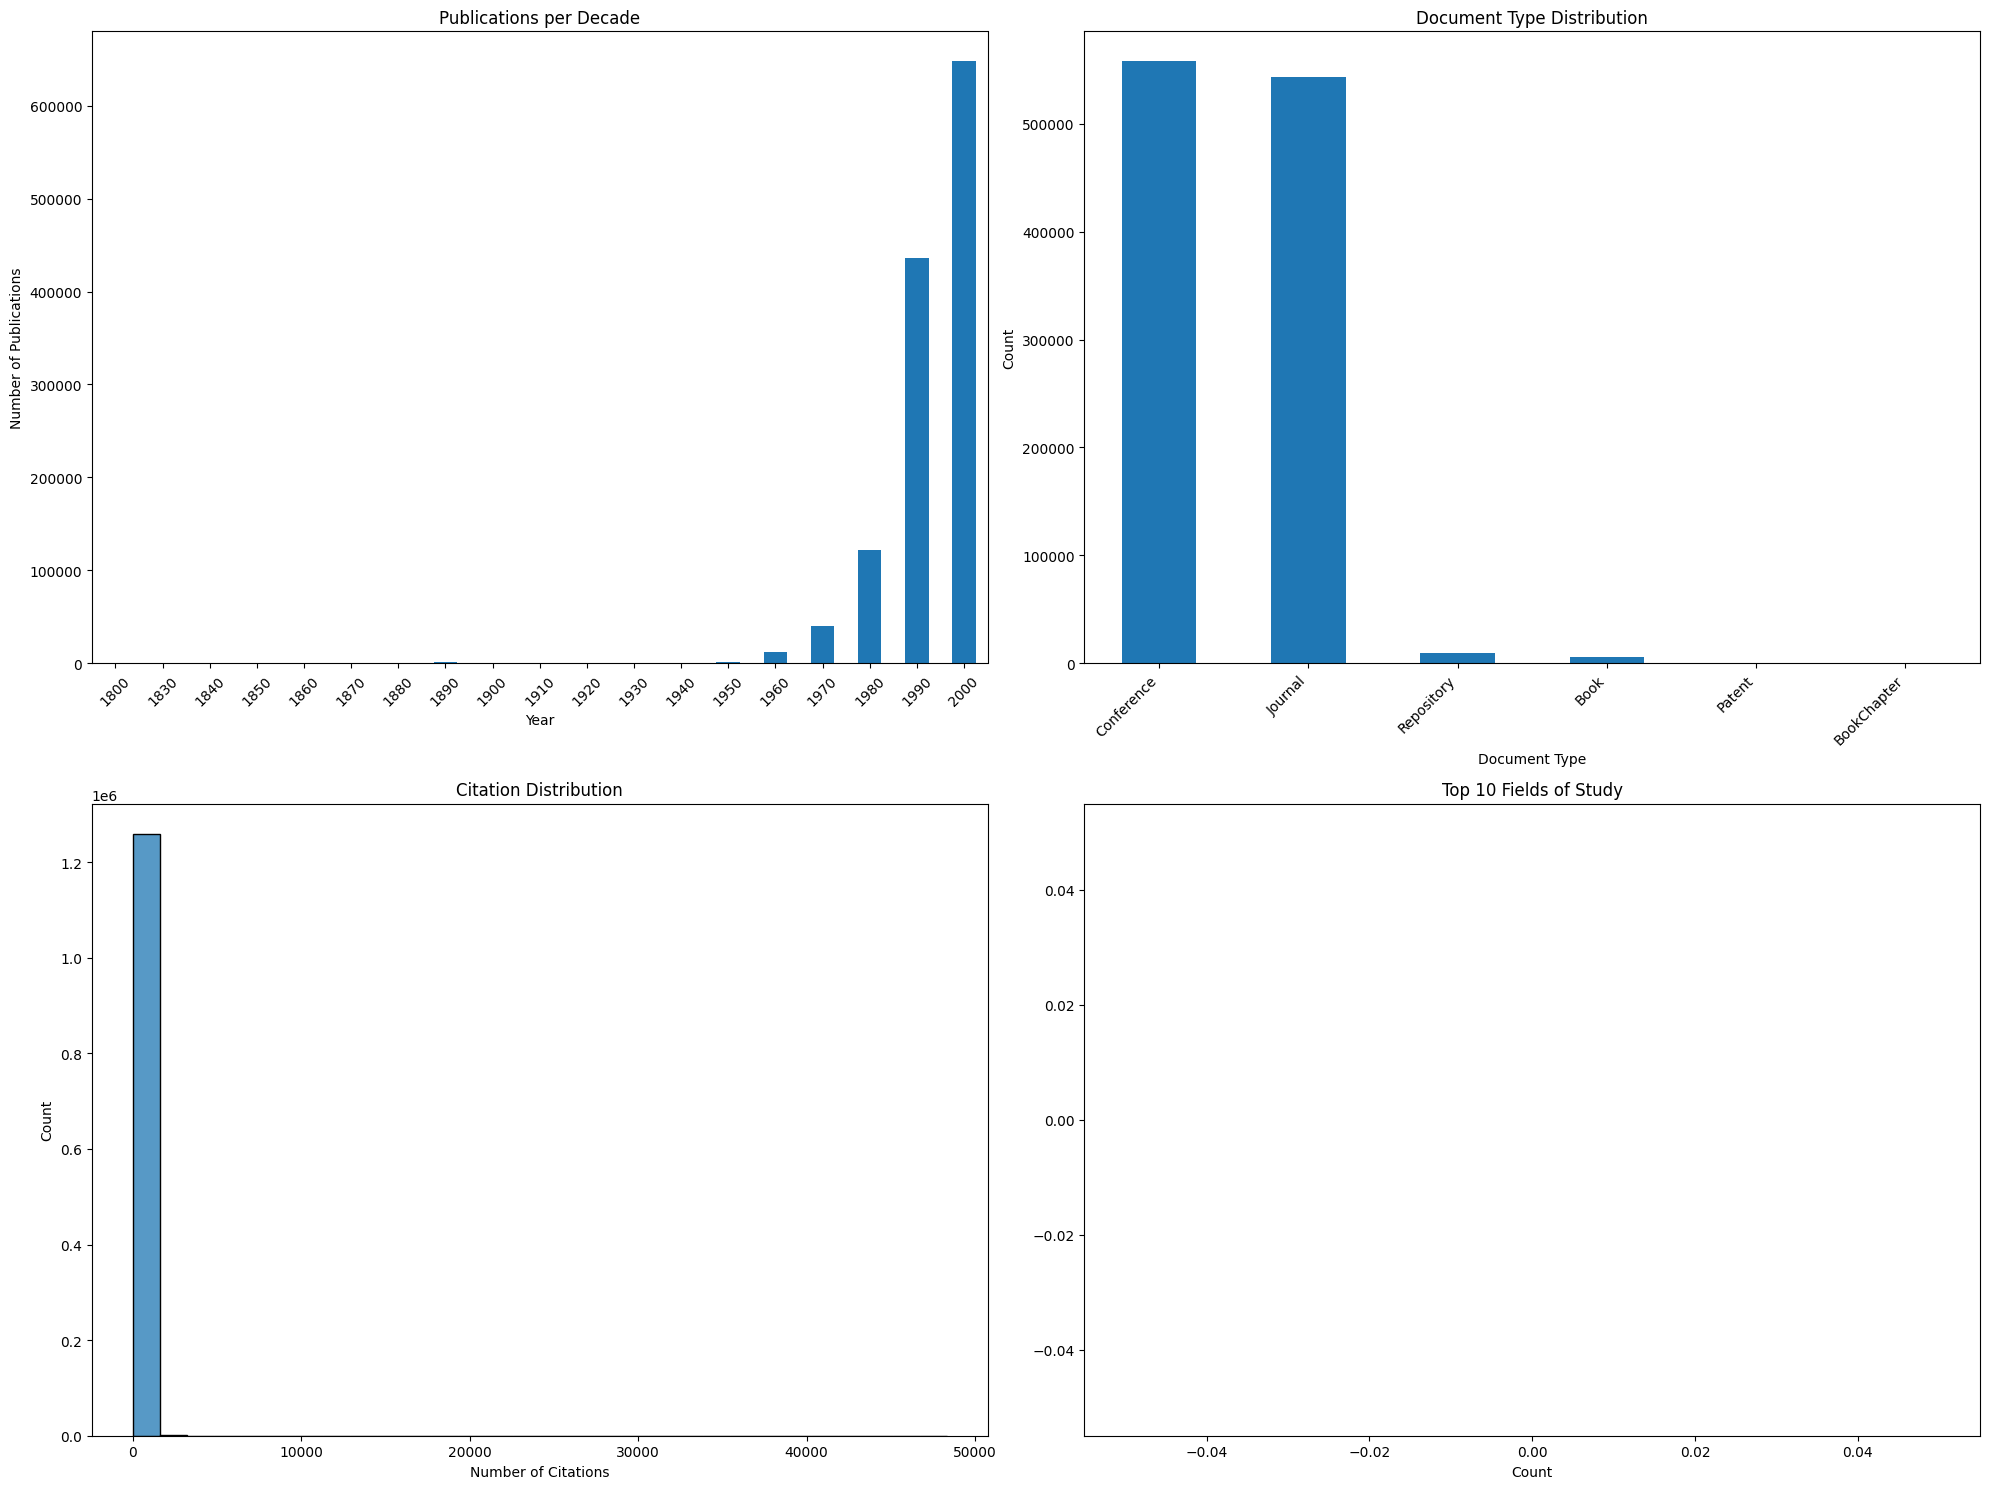

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import community as community_louvain
import networkx as nx
import community.community_louvain as community_louvain
from collections import defaultdict
import numpy as np

df = pd.read_csv("output_filtered_complete.csv")

# Removing the papers with year 0 (datasets with 0 citations, 0 refereneces)
df = df[df['year'] != 0]

# Group the 'year' column into 10-year intervals
df['year_group'] = (df['year'] // 10) * 10

# Create a figure with subplots
fig = plt.figure(figsize=(20, 15))

# 1. Publications per decade (grouped by 10-year intervals)
plt.subplot(2, 2, 1)
year_group_counts = df['year_group'].value_counts().sort_index()
year_group_counts.plot(kind='bar')
plt.title('Publications per Decade')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)

# 2. Document type distribution (now as bar plot)
plt.subplot(2, 2, 2)
doc_type_counts = df['doc_type'].value_counts()
doc_type_counts.plot(kind='bar')
plt.title('Document Type Distribution')
plt.xlabel('Document Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# 3. Citation distribution
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='n_citation', bins=30)
plt.title('Citation Distribution')
plt.xlabel('Number of Citations')
plt.ylabel('Count')

# 4. Analysis of fields of study (FOS)
def extract_fos(fos_str):
    try:
        fos_list = ast.literal_eval(fos_str)
        return [item['name'] for item in fos_list]
    except:
        return []

# Flatten the list of FOS
all_fos = []
for fos in df['fos'].dropna():
    all_fos.extend(extract_fos(fos))

# Get the top 10 most common FOS
fos_counter = Counter(all_fos)
top_fos = dict(sorted(fos_counter.items(), key=lambda x: x[1], reverse=True)[:10])

# Plot FOS distribution
plt.subplot(2, 2, 4)
plt.barh(list(top_fos.keys()), list(top_fos.values()))
plt.title('Top 10 Fields of Study')
plt.xlabel('Count')

plt.tight_layout()
plt.show()


In [56]:
df.head()

id                                              title  year  n_citation  \
0   1388  Further Results on Independence in Direct-Prod...  2000           1   
1   5781                Vectorial fast correlation attacks.  2004           2   
2   6762  A Self-Stabilizing Algorithm for Finding the C...  2003           0   
3  11068  Multisymplectic Spectral Methods for the Gross...  2002           2   
4  11895  Speech training systems using lateral shapes o...  1979           1   

  page_start page_end    doc_type                        publisher  volume  \
0        NaN      NaN     Journal                              NaN    56.0   
1        247      NaN  Repository                              NaN  2004.0   
2       1460     1463  Conference                              NaN     NaN   
3        486      495  Conference     Springer, Berlin, Heidelberg     NaN   
4        800      802  Conference  Morgan Kaufmann Publishers Inc.     NaN   

   issue                       doi  \
0    NaN                       NaN   
1    NaN                       NaN   
2    NaN                       NaN   
3    NaN  10.1007/3-540-47789-6_51   
4    NaN                       NaN   

                                             authors references  \
0       {'name': 'Pranava K. Jha', 'id': 2718958994}        NaN   
1  {'name': 'Jovan Dj. Golic', 'id': 1237859792},...        NaN   
2  {'name': 'Pranay Chaudhuri', 'id': 2142249029}...        NaN   
3  {'name': 'A. L. Islas', 'org': 'Old Dominion u...        NaN   
4  {'name': 'Minoru Shigenaga', 'org': 'Departmen...        NaN   

                                                 fos  year_group  
0  {'name': 'Graph', 'w': Decimal('0.0')}, {'name...        2000  
1  {'name': 'Pattern recognition', 'w': Decimal('...        2000  
2  {'name': 'Computer science', 'w': Decimal('0.4...        2000  
3  {'name': 'Gross–Pitaevskii equation', 'w': Dec...        2000  
4  {'name': 'Speech training', 'w': Decimal('0.0'...        1970

In [2]:
# Rest of the statistical analysis
print("\nDataset Summary:")
print("-" * 50)
print(f"Total number of papers: {len(df)}")
print(f"Date range: {df['year'].min()} - {df['year'].max()}")
print(f"Average citations per paper: {df['n_citation'].mean():.2f}")
print(f"Median citations per paper: {df['n_citation'].median()}")
print(f"Maximum citations for a paper: {df['n_citation'].max()}")


Dataset Summary:
--------------------------------------------------
Total number of papers: 1260644
Date range: 1800 - 2005
Average citations per paper: 31.92
Median citations per paper: 6.0
Maximum citations for a paper: 48327


In [3]:
import pandas as pd
import networkx as nx
import ast
from datetime import datetime


def clean_references(refs):
    """Convert string representation of references to list of integers"""
    if pd.isna(refs):
        return []
    try:
        # Handle string of comma-separated values
        if isinstance(refs, str) and ',' in refs:
            return [int(ref.strip()) for ref in refs.split(',') if ref.strip().isdigit()]
        # Handle single integer
        elif isinstance(refs, (int, float)):
            return [int(refs)]
        return []
    except:
        return []

def parse_authors(authors_str):
    """Parse authors string to list of dictionaries"""
    if pd.isna(authors_str):
        return []
    try:
        # If it's already a dict, return it in a list
        if isinstance(authors_str, dict):
            return [authors_str]
        # Try to evaluate string representation of dict/list
        authors = ast.literal_eval(authors_str)
        if isinstance(authors, dict):
            return [authors]
        return authors
    except:
        return []

def parse_fos(fos_str):
    """Parse field of study string to list of dictionaries"""
    if pd.isna(fos_str):
        return []
    try:
        return ast.literal_eval(fos_str)
    except:
        return []

def create_citation_graph(df):
    """Create a directed graph from citation data with properties"""
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes (papers) with their properties
    for _, row in df.iterrows():
        # Basic properties
        node_props = {
            'title': row['title'] if pd.notna(row['title']) else '',
            'year': int(row['year']) if pd.notna(row['year']) else None,
            'n_citation': int(row['n_citation']) if pd.notna(row['n_citation']) else 0,
            'doc_type': row['doc_type'] if pd.notna(row['doc_type']) else '',
            'publisher': row['publisher'] if pd.notna(row['publisher']) else '',
            'volume': row['volume'] if pd.notna(row['volume']) else '',
            'doi': row['doi'] if pd.notna(row['doi']) else '',
        }
        
        # Parse and add authors
        authors = parse_authors(row['authors'])
        node_props['author_names'] = [author.get('name', '') for author in authors]
        node_props['author_ids'] = [author.get('id', '') for author in authors]
        node_props['author_orgs'] = [author.get('org', '') for author in authors]
        
        # Parse and add fields of study
        fos = parse_fos(row['fos'])
        node_props['fields_of_study'] = [field.get('name', '') for field in fos]
        node_props['field_weights'] = [float(field.get('w', 0)) for field in fos]
        
        # Add node with all properties
        G.add_node(row['id'], **node_props)
        
        # Add edges (citations)
        references = clean_references(row['references'])
        for ref_id in references:
            # Add edge with properties
            G.add_edge(row['id'], ref_id, 
                      citing_year=node_props['year'],
                      weight=1)  # weight can be used for citation strength

    return G

# Create the graph
G = create_citation_graph(df)

# Print graph summary
print("\nGraph Summary:")
print(f"Number of nodes (papers): {G.number_of_nodes()}")
print(f"Number of edges (citations): {G.number_of_edges()}")

# Print some basic network metrics
print("\nNetwork Metrics:")
print(f"Average in-degree (citations received): {sum(dict(G.in_degree()).values())/G.number_of_nodes():.2f}")
print(f"Average out-degree (citations made): {sum(dict(G.out_degree()).values())/G.number_of_nodes():.2f}")

# Example of accessing node properties

#if G.nodes():
#    sample_node = list(G.nodes())[0]
#    print(f"\nSample node (Paper ID: {sample_node}) properties:")
#    for key, value in G.nodes[sample_node].items():
#        print(f"{key}: {value}")
#
# Calculate some basic network statistics

#print("\nNetwork Statistics:")
#print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
#try:
#    print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
#except:
#    print("Average clustering coefficient: N/A (empty or disconnected graph)")


Graph Summary:
Number of nodes (papers): 1270321
Number of edges (citations): 7249348

Network Metrics:
Average in-degree (citations received): 5.71
Average out-degree (citations made): 5.71


In [4]:
G2 = G.to_undirected()


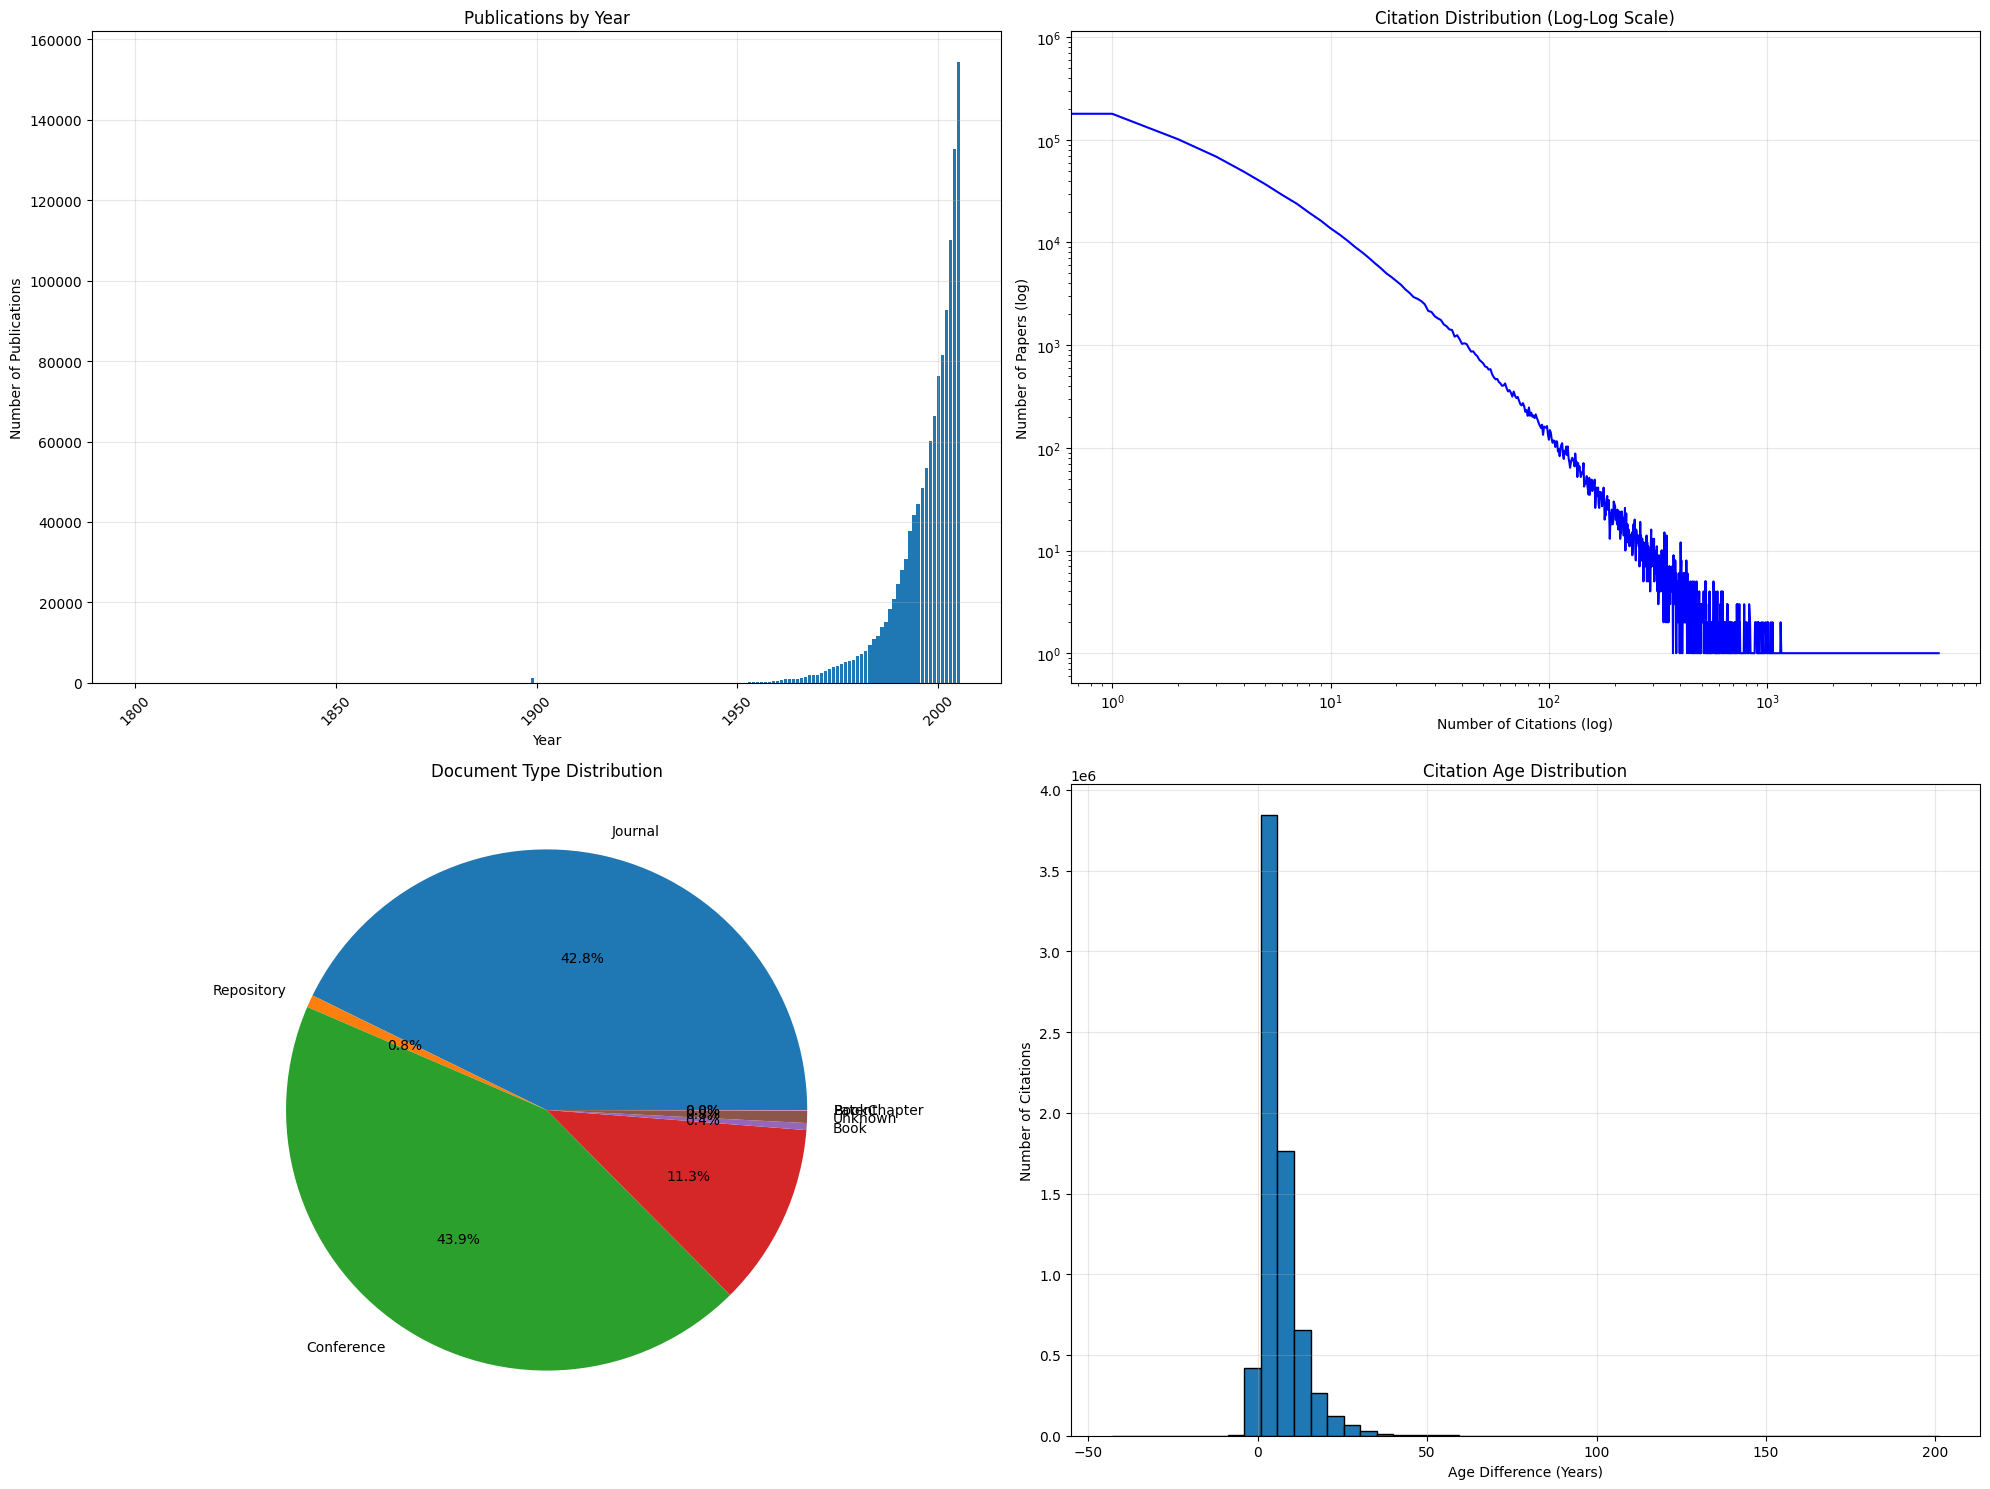

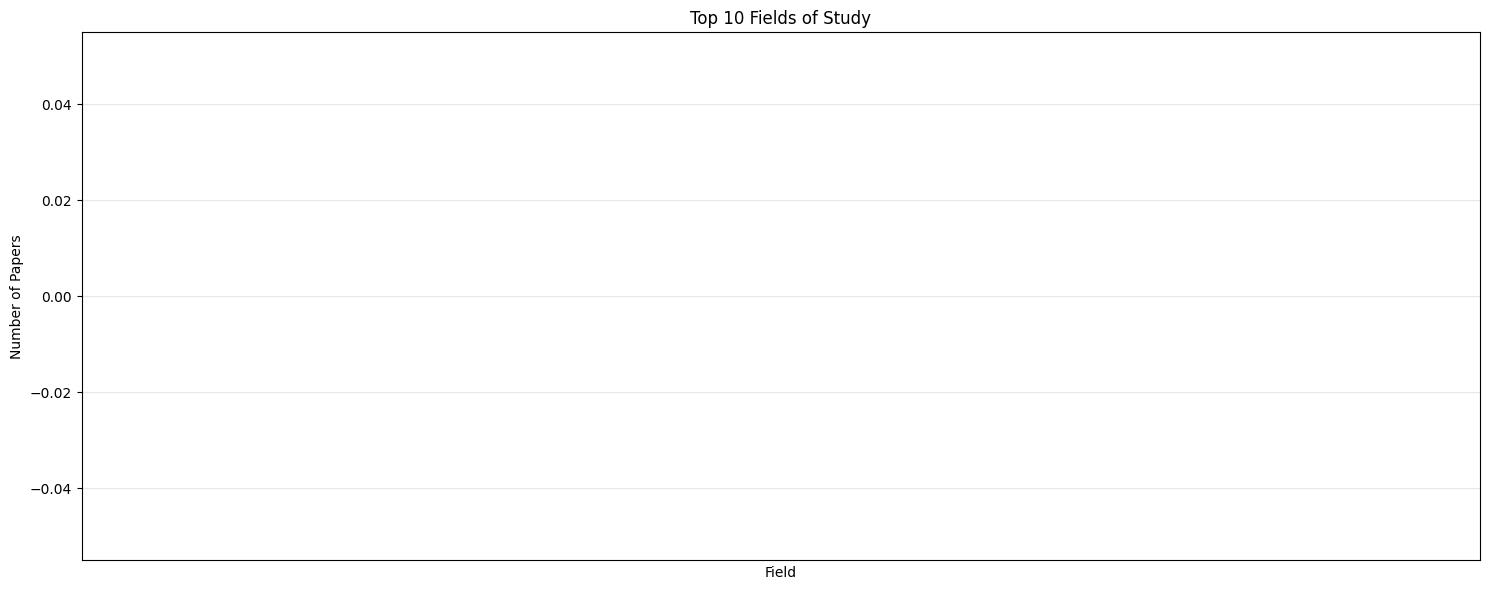

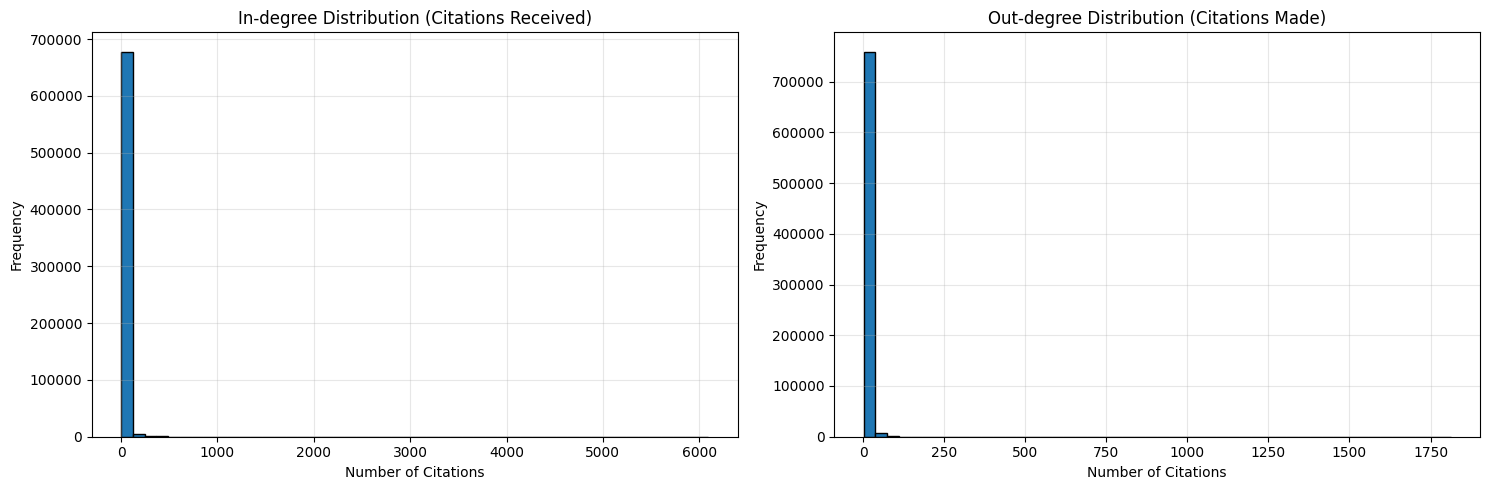

In [58]:
import matplotlib.pyplot as plt
from collections import Counter

# Year Distribution
years = {}
for node in G.nodes():
    year = G.nodes[node].get('year')
    if year is not None:
        years[year] = years.get(year, 0) + 1
        
# Citation Statistics
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())


doc_types = {}
for node in G.nodes():
    doc_type = G.nodes[node].get('doc_type', 'Unknown')
    doc_types[doc_type] = doc_types.get(doc_type, 0) + 1


# Field of Study Analysis
fields = {}
for node in G.nodes():
    node_fields = G.nodes[node].get('fields_of_study', [])
    for field in node_fields:
        fields[field] = fields.get(field, 0) + 1
# Citation Patterns Over Time
temporal_citations = {}
for u, v in G.edges():
    citing_year = G.nodes[u].get('year')
    cited_year = G.nodes[v].get('year')
    if citing_year and cited_year:
        age = citing_year - cited_year
        temporal_citations[age] = temporal_citations.get(age, 0) + 1

# Create figure with subplots
plt.figure(figsize=(20, 15))

# 1. Year Distribution
plt.subplot(2, 2, 1)
year_counts = Counter(years)
years_sorted = sorted(year_counts.keys())
plt.bar(years_sorted, [year_counts[year] for year in years_sorted])
plt.title('Publications by Year', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 2. Citation Distribution (log scale)
plt.subplot(2, 2, 2)
in_degree_counts = Counter(in_degrees.values())
degrees_sorted = sorted(in_degree_counts.keys())
plt.loglog(degrees_sorted, [in_degree_counts[d] for d in degrees_sorted], 'b-')
plt.title('Citation Distribution (Log-Log Scale)', fontsize=12)
plt.xlabel('Number of Citations (log)')
plt.ylabel('Number of Papers (log)')
plt.grid(True, alpha=0.3)

# 3. Document Type Distribution
plt.subplot(2, 2, 3)
doc_type_counts = Counter(doc_types)
plt.pie([v for v in doc_type_counts.values()], 
        labels=[k for k in doc_type_counts.keys()],
        autopct='%1.1f%%')
plt.title('Document Type Distribution', fontsize=12)

# 4. Citation Age Distribution
plt.subplot(2, 2, 4)
plt.hist(list(temporal_citations.keys()), 
         weights=list(temporal_citations.values()), 
         bins=50, 
         edgecolor='black')
plt.title('Citation Age Distribution', fontsize=12)
plt.xlabel('Age Difference (Years)')
plt.ylabel('Number of Citations')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional visualization: Top 10 Fields of Study
plt.figure(figsize=(15, 6))
field_counts = Counter(fields)
top_fields = dict(sorted(field_counts.items(), key=lambda x: x[1], reverse=True)[:10])
plt.bar(range(len(top_fields)), list(top_fields.values()))
plt.xticks(range(len(top_fields)), list(top_fields.keys()), rotation=45, ha='right')
plt.title('Top 10 Fields of Study', fontsize=12)
plt.xlabel('Field')
plt.ylabel('Number of Papers')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Degree Distribution Analysis
plt.figure(figsize=(15, 5))

# In-degree distribution
plt.subplot(1, 2, 1)
in_degree_dist = [d for d in in_degrees.values() if d > 0]
plt.hist(in_degree_dist, bins=50, edgecolor='black')
plt.title('In-degree Distribution (Citations Received)', fontsize=12)
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Out-degree distribution
plt.subplot(1, 2, 2)
out_degree_dist = [d for d in out_degrees.values() if d > 0]
plt.hist(out_degree_dist, bins=50, edgecolor='black')
plt.title('Out-degree Distribution (Citations Made)', fontsize=12)
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

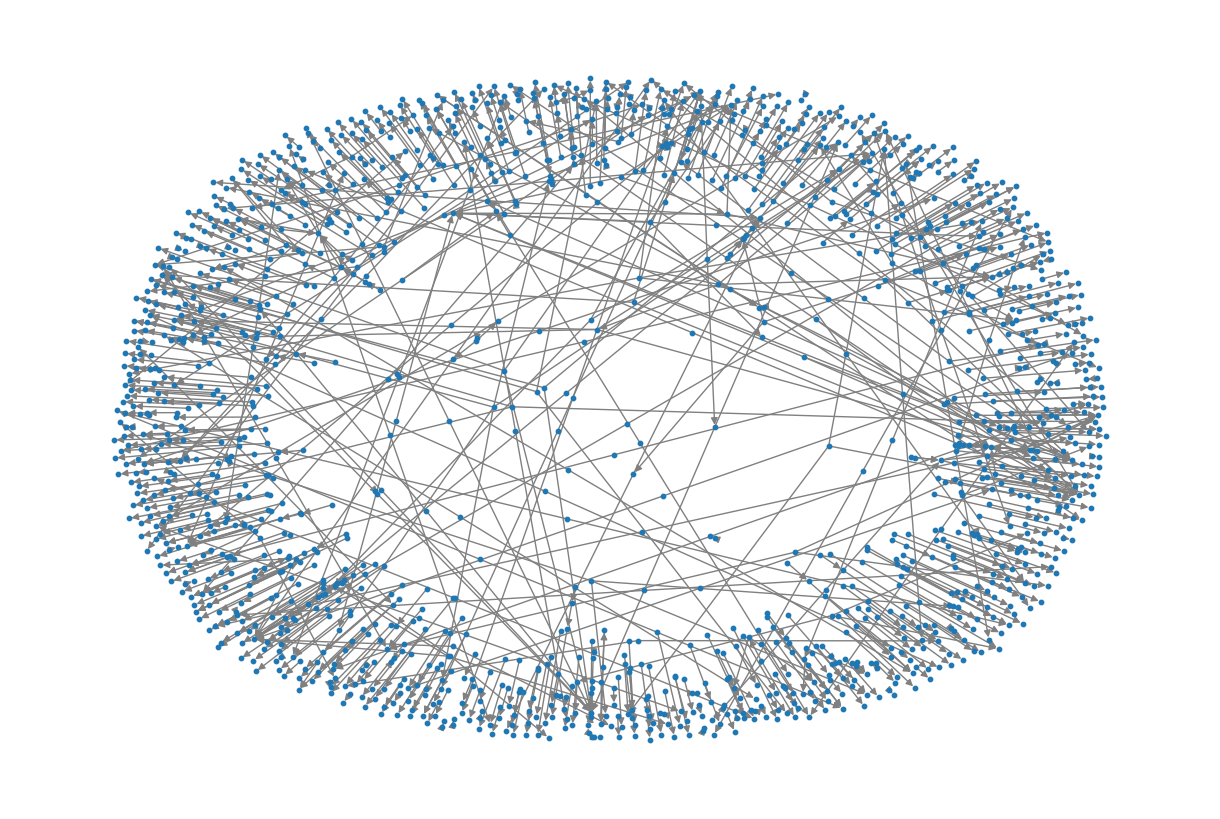

In [60]:


# Number of edges to sample
num_edges = 800  # Adjust based on your preference

# Sample random edges from the graph
sampled_edges = random.sample(list(G.edges()), num_edges)

# Extract nodes from these edges
sampled_nodes = set()
for u, v in sampled_edges:
    sampled_nodes.add(u)
    sampled_nodes.add(v)

# Create a subgraph with these nodes and edges
G_sub = G.subgraph(sampled_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 8))
nx.draw(G_sub, with_labels=False, node_size=10, edge_color="gray", font_size=6)
plt.show()

Text(0.5, 1.0, 'Subgraph with 989 nodes and 1000 edges')

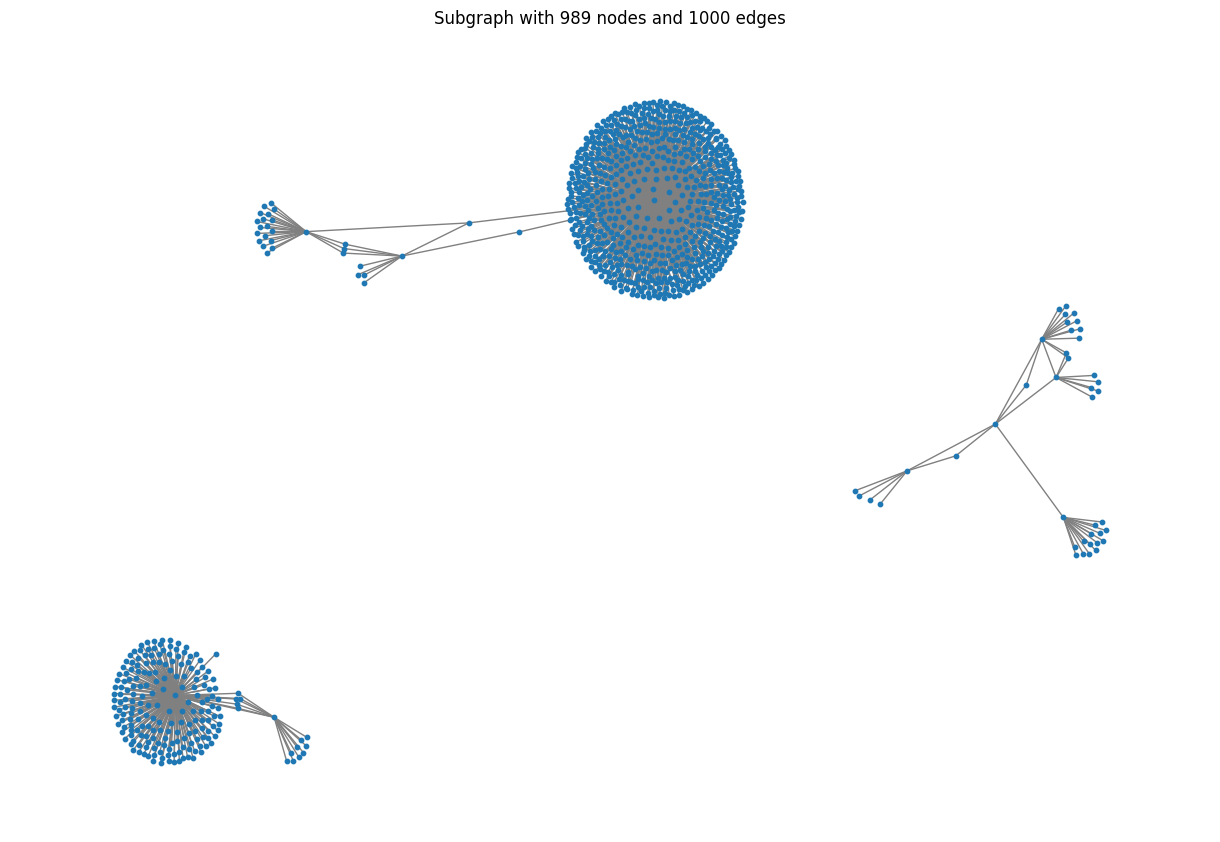

In [5]:
G_und = G2


# Get nodes with degree >= 3
nodes_with_min_degree = [node for node, degree in G.degree() if degree >= 3]

# Create subgraph with these nodes
G_sub = G_und.subgraph(nodes_with_min_degree)

# Keep only the largest connected component
largest_cc = max(nx.connected_components(G_sub), key=len)
G_sub = G_sub.subgraph(largest_cc)

# Get list of edges sorted by weight
edges = sorted(G_sub.edges(data=True), key=lambda x: x[2].get('weight', 0), reverse=True)

# Keep only top N edges
N = 1000  # Adjust this number as needed
top_edges = edges[:N]
G_filtered = nx.Graph()
G_filtered.add_edges_from(top_edges)

# Draw the filtered subgraph
plt.figure(figsize=(12, 8))
nx.draw(G_filtered, 
        with_labels=False,
        node_size=10,
        edge_color="gray",
        font_size=6)
plt.title(f'Subgraph with {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges')


Starting community detection analysis...

Running Louvain algorithm...


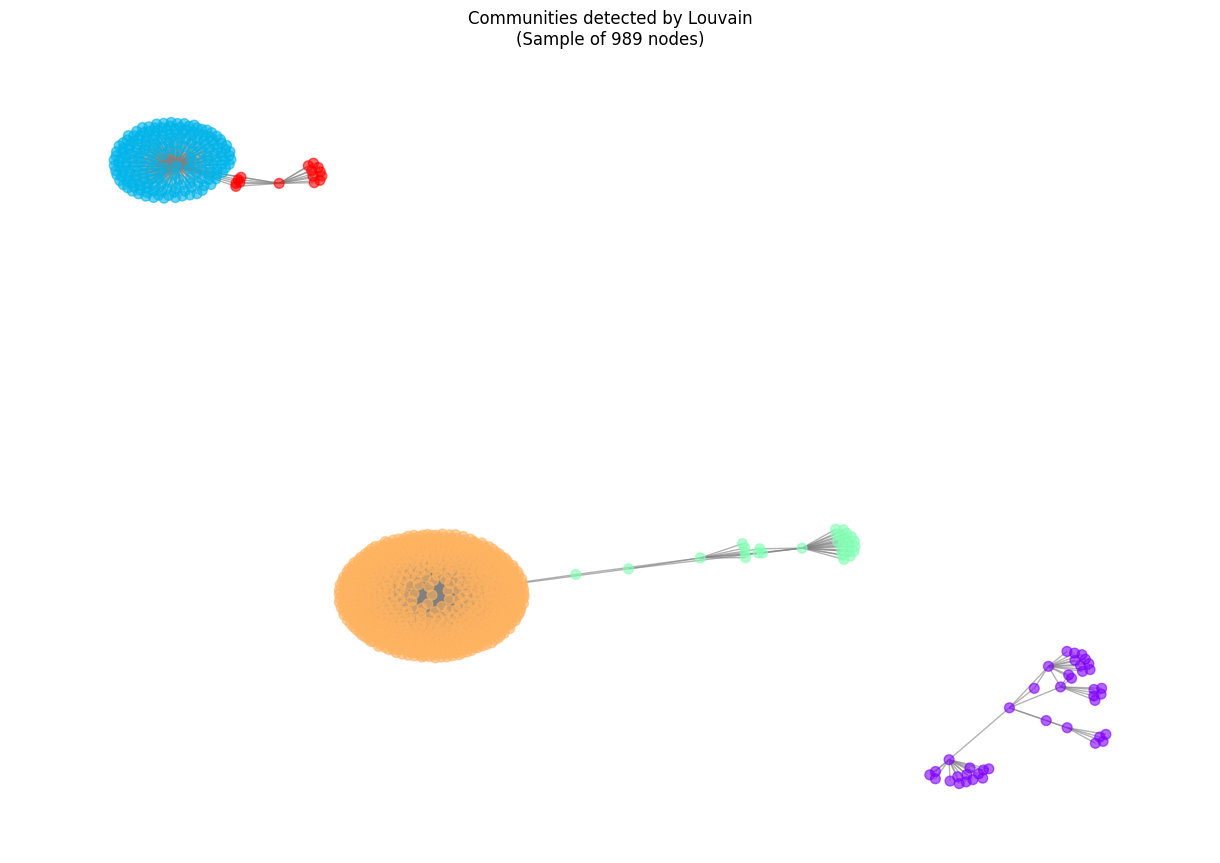

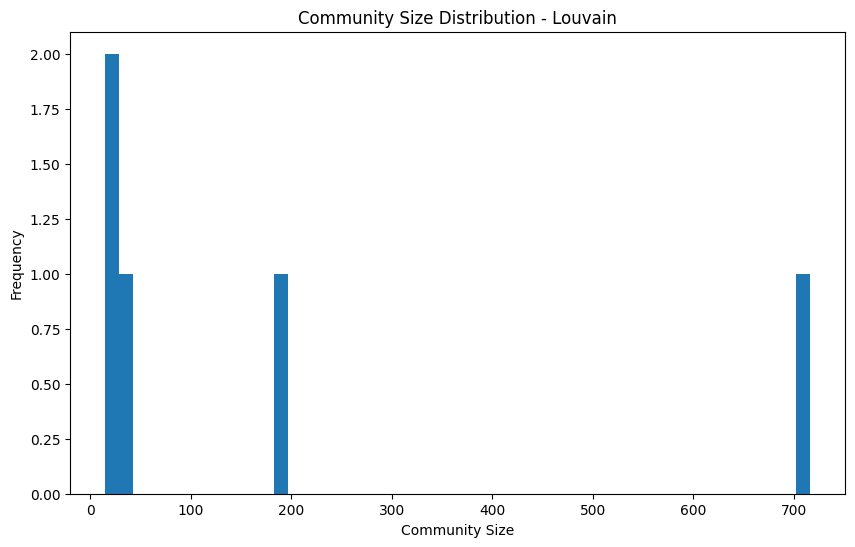


Analysis of Louvain communities:

Community 1 (Size: 716)
Document types: {'Unknown': 716}
Internal density: 0.003

Community 2 (Size: 188)
Document types: {'Unknown': 188}
Internal density: 0.011

Community 3 (Size: 41)
Document types: {'Unknown': 41}
Internal density: 0.055

Community 4 (Size: 29)
Document types: {'Unknown': 29}
Internal density: 0.076

Community 5 (Size: 15)
Document types: {'Unknown': 15}
Internal density: 0.133

Running Girvan-Newman algorithm...


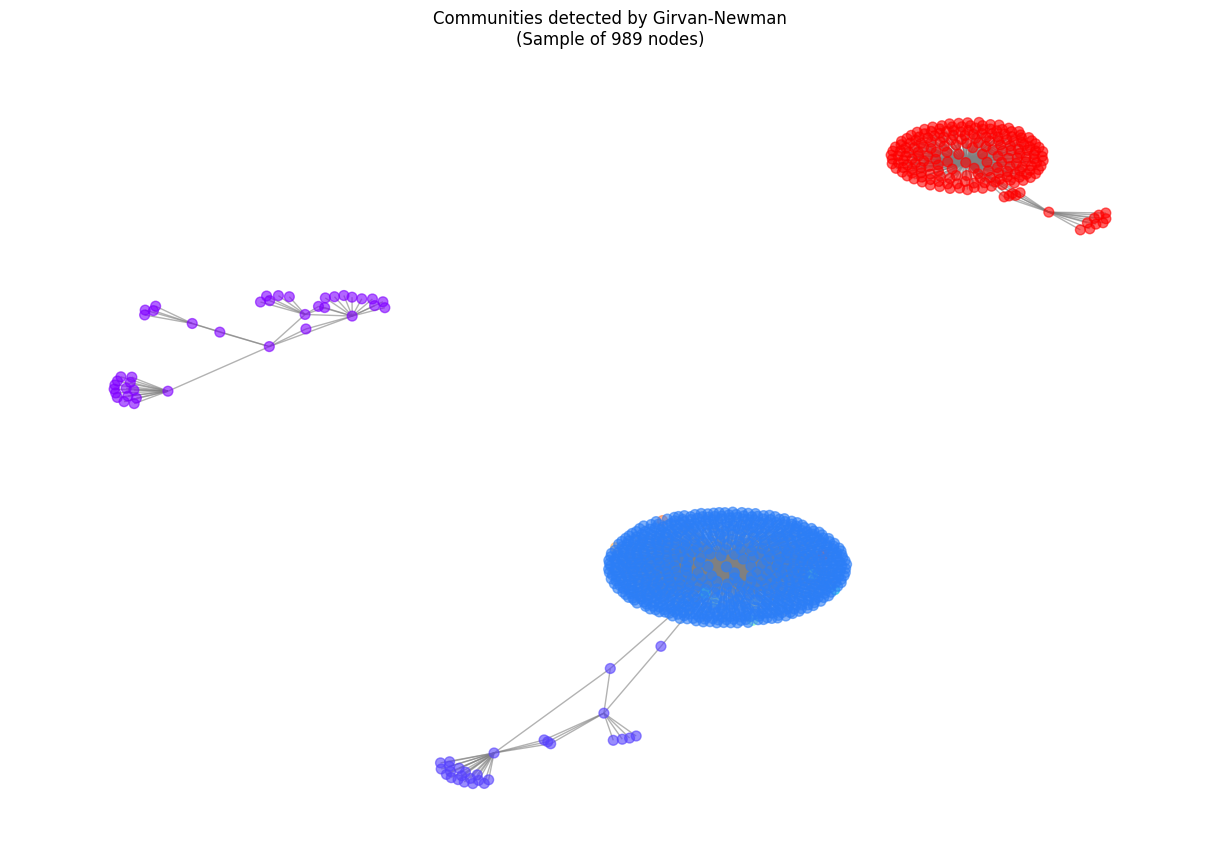

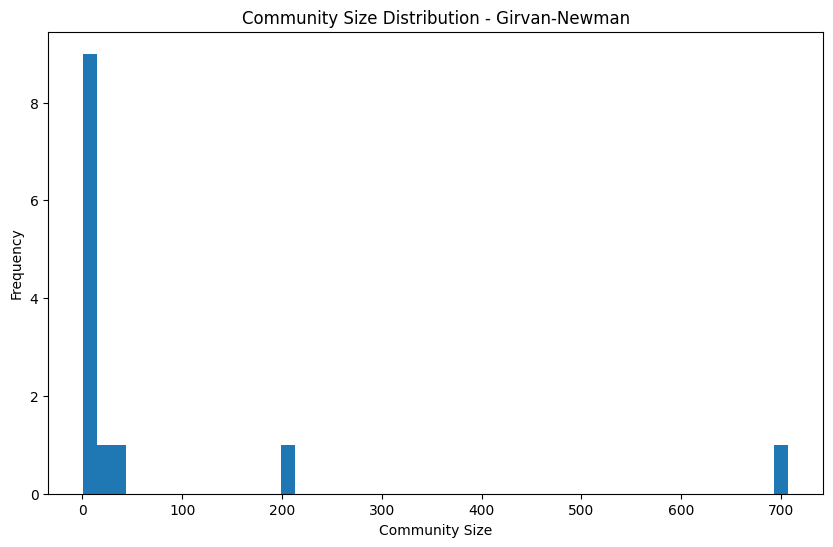


Analysis of Girvan-Newman communities:

Community 1 (Size: 707)
Document types: {'Unknown': 707}
Internal density: 0.003

Community 2 (Size: 203)
Document types: {'Unknown': 203}
Internal density: 0.010

Community 3 (Size: 41)
Document types: {'Unknown': 41}
Internal density: 0.055

Community 4 (Size: 29)
Document types: {'Unknown': 29}
Internal density: 0.076

Community 5 (Size: 1)
Document types: {'Unknown': 1}
Internal density: 0.000

Comparative Results:

modularity:
Louvain: 0.4399
Girvan-Newman: 0.4369

n_communities:
Louvain: 5.0000
Girvan-Newman: 13.0000

avg_community_size:
Louvain: 197.8000
Girvan-Newman: 76.0769

avg_internal_density:
Louvain: 0.0556
Girvan-Newman: 0.0111

Nodes in each community:

Louvain communities:
Community 0: [13205, 86048793, 1584320209, 1921940208, 2096518980, 1587401114, 2329894779, 157033067, 1580810326, 2062337664, 2086875012, 2147885303, 2156718546, 2295661697, 2405178625, 2405864060, 177343695, 2082065596, 118119807, 149550142, 2154716737, 2147

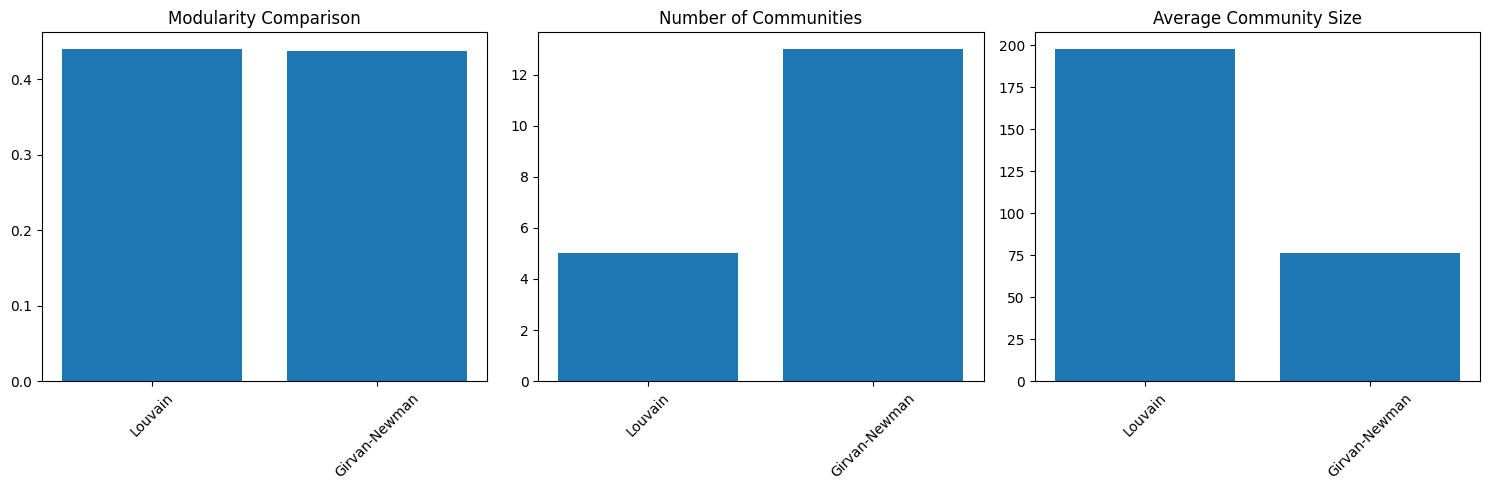

In [6]:


def evaluate_communities(G, communities):
    """Evaluate community detection results"""
    results = {}
    
    # 1. Modularity (using community_louvain)
    try:
        modularity = community_louvain.modularity(communities, G)
        results['modularity'] = modularity
    except Exception as e:
        print(f"Error calculating modularity: {e}")
        results['modularity'] = None
    
    # 2. Number of communities
    n_communities = len(set(communities.values()))
    results['n_communities'] = n_communities
    
    # 3. Community size distribution
    community_sizes = defaultdict(int)
    for node, community in communities.items():
        community_sizes[community] += 1
    
    results['avg_community_size'] = np.mean(list(community_sizes.values()))
    results['std_community_size'] = np.std(list(community_sizes.values()))
    
    # 4. Internal density
    internal_density = {}
    for comm_id in set(communities.values()):
        comm_nodes = [n for n, c in communities.items() if c == comm_id]
        subgraph = G.subgraph(comm_nodes)
        internal_density[comm_id] = nx.density(subgraph)
    
    results['avg_internal_density'] = np.mean(list(internal_density.values()))
    
    # 5. Additional metrics
    results['max_community_size'] = max(community_sizes.values())
    results['min_community_size'] = min(community_sizes.values())
    
    return results

def detect_communities_louvain(G):
    """Detect communities using Louvain method"""
    # Convert to undirected graph for Louvain
    G_undirected = G.to_undirected()
    return community_louvain.best_partition(G_undirected)

def detect_communities_label_prop(G):
    """Detect communities using Label Propagation"""
    communities = nx.community.label_propagation_communities(G)
    community_dict = {}
    for i, community in enumerate(communities):
        for node in community:
            community_dict[node] = i
    return community_dict

def detect_communities_girvan_newman(G, k=10):
    """Detect communities using Girvan-Newman algorithm"""
    comp = nx.community.girvan_newman(G)
    communities = None
    for i, c in enumerate(comp):
        if i == k-1:
            communities = c
            break
    
    community_dict = {}
    for i, community in enumerate(communities):
        for node in community:
            community_dict[node] = i
    return community_dict

def analyze_community_characteristics(G, communities, algorithm_name):
    """Analyze characteristics of detected communities"""
    community_groups = defaultdict(list)
    for node, comm in communities.items():
        community_groups[comm].append(node)
    
    print(f"\nAnalysis of {algorithm_name} communities:")
    
    # Get top 5 largest communities
    top_communities = sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True)[:5]
    
    for i, (comm_id, nodes) in enumerate(top_communities, 1):
        print(f"\nCommunity {i} (Size: {len(nodes)})")
        
        # Analyze years
        years = [G.nodes[node].get('year', 0) for node in nodes if G.nodes[node].get('year', 0) != 0]
        if years:
            print(f"Year range: {min(years)} - {max(years)}")
            print(f"Average year: {np.mean(years):.1f}")
        
        # Analyze document types
        doc_types = defaultdict(int)
        for node in nodes:
            doc_type = G.nodes[node].get('doc_type', 'Unknown')
            doc_types[doc_type] += 1
        print("Document types:", dict(doc_types))
        
        # Analyze fields of study
        fields = defaultdict(int)
        for node in nodes:
            for field in G.nodes[node].get('fields_of_study', []):
                if field:  # Skip empty fields
                    fields[field] += 1
        
        if fields:
            print("Top 3 fields of study:")
            for field, count in sorted(fields.items(), key=lambda x: x[1], reverse=True)[:3]:
                print(f"- {field}: {count}")
        
        # Calculate internal density
        subgraph = G.subgraph(nodes)
        density = nx.density(subgraph)
        print(f"Internal density: {density:.3f}")

def visualize_communities(G, communities, algorithm_name, sample_size=1000):
    """Visualize a sample of the communities"""
    # Sample nodes
    nodes = list(G.nodes())
    if len(nodes) > sample_size:
        sampled_nodes = np.random.choice(nodes, sample_size, replace=False)
        G_sample = G.subgraph(sampled_nodes)
    else:
        G_sample = G

    # Create layout
    pos = nx.spring_layout(G_sample, k=1/np.sqrt(len(G_sample)), iterations=50)
    
    # Draw the network
    plt.figure(figsize=(12, 8))
    colors = [communities[node] for node in G_sample.nodes()]
    nx.draw(G_sample, pos, 
            node_color=colors, 
            node_size=50, 
            edge_color='gray', 
            alpha=0.6, 
            with_labels=False,
            cmap=plt.cm.rainbow)
    
    plt.title(f'Communities detected by {algorithm_name}\n(Sample of {len(G_sample)} nodes)')
    plt.show()
    
    # Plot community size distribution
    plt.figure(figsize=(10, 6))
    community_sizes = defaultdict(int)
    for node, comm in communities.items():
        community_sizes[comm] += 1
    plt.hist(community_sizes.values(), bins=50)
    plt.title(f'Community Size Distribution - {algorithm_name}')
    plt.xlabel('Community Size')
    plt.ylabel('Frequency')
    plt.show()

# Run the analysis
print("Starting community detection analysis...")

# Dictionary to store results
results = {}
community_nodes = {}  # Dictionary to store nodes for each community

# Convert graph to undirected before running algorithms
G_undirected = G_filtered

# Run each algorithm
algorithms = {
    'Louvain': detect_communities_louvain,
    #'Label Propagation': detect_communities_label_prop,
    'Girvan-Newman': detect_communities_girvan_newman
}

for name, algorithm in algorithms.items():
    print(f"\nRunning {name} algorithm...")
    try:
        communities = algorithm(G_undirected)
        results[name] = evaluate_communities(G_undirected, communities)
        
        # Store nodes for each community
        community_nodes[name] = defaultdict(list)
        for node, comm_id in communities.items():
            community_nodes[name][comm_id].append(node)
        
        # Visualize communities
        visualize_communities(G_undirected, communities, name)
        
        # Analyze communities
        analyze_community_characteristics(G_undirected, communities, name)
        
    except Exception as e:
        print(f"Error running {name}: {str(e)}")

# Print comparative results
print("\nComparative Results:")
metrics = ['modularity', 'n_communities', 'avg_community_size', 'avg_internal_density']
for metric in metrics:
    print(f"\n{metric}:")
    for algorithm in results:
        if metric in results[algorithm]:
            print(f"{algorithm}: {results[algorithm][metric]:.4f}")

# Print nodes in each community
print("\nNodes in each community:")
for algorithm, communities in community_nodes.items():
    print(f"\n{algorithm} communities:")
    for comm_id, nodes in communities.items():
        print(f"Community {comm_id}: {nodes}")

# Visualize comparative results
plt.figure(figsize=(15, 5))

# Plot modularity comparison
plt.subplot(131)
modularities = [results[alg]['modularity'] for alg in results if results[alg]['modularity'] is not None]
plt.bar(results.keys(), modularities)
plt.title('Modularity Comparison')
plt.xticks(rotation=45)

# Plot number of communities
plt.subplot(132)
n_communities = [results[alg]['n_communities'] for alg in results]
plt.bar(results.keys(), n_communities)
plt.title('Number of Communities')
plt.xticks(rotation=45)

# Plot average community size
plt.subplot(133)
avg_sizes = [results[alg]['avg_community_size'] for alg in results] 
plt.bar(results.keys(), avg_sizes)
plt.title('Average Community Size')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [36]:
#Louvain communities result:
community_0 = [13205, 86048793, 1584320209, 1921940208, 2096518980, 1587401114, 2329894779, 157033067, 1580810326, 2062337664, 2086875012, 2147885303, 2156718546, 2295661697, 2405178625, 2405864060, 177343695, 2082065596, 118119807, 149550142, 2154716737, 2147333232, 1481698486, 1590962860, 1523691617, 1516767052, 1833309139, 1837953807, 1574718645, 1860939371, 1882516017, 2163910652, 202482880, 2024490156, 1503040910, 1985953361, 47448020, 1621432539, 2428180336, 1565258258, 1929944414]
community_2 = [27301, 1511704096, 1952358266, 144112633, 1486577799, 2103428301, 1976690033, 1510557872, 2145984417, 2155435240, 2186074972, 1641167210, 1678628042, 1775663022, 2914036917, 43013318, 1528968435, 2096392987, 1495362911, 1542607456, 2113389047, 2019352037, 2076398593, 2046738999, 2054632854, 2085816455, 2097329560, 1665188640, 2142111788]
community_3 = [2916302273, 2122440889, 1548516269, 1721190297, 2006664424, 2150623502, 2245636100, 2099040451, 2068310911, 2156849122, 1507739880, 1656678770, 2159945176, 2105470748, 2131300413, 1949661937, 2033751220, 1495653136, 2107515440, 2097725665, 2087761759, 2169194339, 2101325954, 2119030343, 2150228605, 2160878415, 2000916586, 2103243421, 2151834701, 2112578244, 1552695147, 1549289012, 2008272678, 2135708813, 22379216, 2263124607, 1936730819, 25271894, 1866067016, 2122984309, 2112254905, 1542059364, 30824666, 1645506484, 2052267638, 2166462813, 1799494930, 2147342997, 2148848042, 2174595797, 2049217529, 1540487166, 2100849134, 2087635499, 2038121473, 2131089863, 34980683, 2104633167, 2125979804, 35528529, 2126087831, 2167392728, 2037515303, 2140327371, 2099035338, 1639145229, 1549202317, 1749834041, 2110491615, 2154081981, 2160170538, 1529431313, 2134349600, 2162653919, 2130459259, 2155464332, 50998170, 1563149761, 2095675261, 2135759164, 1609673577, 1601379374, 2115106301, 2107165730, 2148156724, 2167627865, 2144789220, 2103910180, 2150220944, 2136975273, 2170436791, 1499375855, 2102182691, 62667645, 1591302859, 1686269893, 64923910, 2146567535, 2099817583, 2167569963, 2114579022, 2166618966, 2141963324, 71861115, 72199783, 2100762331, 2006591097, 120084055, 2089573388, 76634321, 2105971467, 2263287114, 2168169496, 81015123, 2132233293, 2036892464, 2024149550, 2073647148, 2165927985, 2154813713, 1511819538, 2112562210, 2009766335, 2132317085, 2148662748, 2128023681, 1993865637, 1582713334, 2108475361, 2504511403, 200765594, 91103066, 1554492461, 2122426592, 2075069529, 1973061330, 1610349667, 97170972, 2162329894, 2010507480, 1510629217, 1540834397, 1499074627, 2151748484, 2120154759, 2023159613, 1970378585, 103888290, 2103239853, 2159176173, 2124009922, 2395078973, 2155903209, 1484377343, 161166442, 2272023646, 2118052422, 112269065, 2115255265, 2139033758, 2177058407, 2095792082, 1750553315, 1974303722, 2142774189, 2097024276, 1988643807, 2141216914, 2154566914, 1599281790, 2407933944, 1591620981, 1579078479, 1517650281, 1591971100, 1746730016, 2130238828, 1584593262, 128319768, 2107580968, 2170246220, 1550632479, 1577629062, 2040325382, 1504078641, 2026839093, 2140733653, 2154816774, 141504034, 2162128713, 1817049307, 2147104476, 2165071399, 2126041223, 147533720, 2077409330, 2138370688, 2030944258, 2157869550, 1558230724, 2072463110, 151443290, 2124371582, 1975925579, 2950993818, 1830272470, 2143712089, 2125673941, 2143840553, 2294212934, 2914970504, 2102101901, 2122159260, 2171517247, 1512273652, 173468605, 2166278075, 174317439, 1558673256, 180719159, 2126187959, 2135133422, 1986411436, 2172433705, 2100562765, 197483027, 1489155257, 1721223458, 2046245985, 1758531722, 1571218544, 2165482045, 1841155531, 2153908688, 244174002, 1970808997, 2151863014, 2143929423, 2166093784, 2008133154, 1491388917, 1851023053, 2127124188, 1479935564, 1987603655, 1602741346, 2121522279, 2139646222, 2115348994, 1482169900, 2038837571, 2136262545, 1590624619, 1986199670, 1482665740, 2053123811, 1483289679, 2122014146, 2164149934, 1934794953, 1791608988, 1545925316, 2107598890, 2163236524, 1484469549, 1485189405, 1485284163, 1485300360, 2148555789, 1486522249, 2152377620, 2087233967, 2151902468, 2063451181, 2113038805, 2161532103, 1489149111, 2157047743, 1584546391, 1522648919, 1558930600, 2080907979, 2102248734, 2141134830, 2164840593, 2118036973, 1526619693, 2127137171, 1883754390, 1998738742, 1492412085, 2106183460, 2118445235, 2039594335, 2042294620, 2121098716, 2131243669, 1494920542, 2026522166, 2133044762, 2018505857, 2044584990, 1495104849, 1767494015, 2119343147, 2160255280, 2145965403, 1653253285, 1497685867, 2005978338, 1596576235, 2131595204, 1499348090, 1947147078, 2136025860, 2033075522, 1500040600, 1555841012, 1766160141, 1571187854, 1501549751, 1561395581, 1484186461, 2112058355, 1502616279, 2128962932, 1503230992, 1504695911, 1597600164, 2109721530, 1503405832, 1503725231, 1503961479, 2166554745, 2062477286, 1505044221, 2000791436, 2158381816, 1505941344, 2030389202, 1507565831, 1507669520, 1507856613, 1507941828, 1508301576, 2131128671, 1597200089, 1510693470, 2148576260, 1510911772, 2077583140, 1512443456, 1591035421, 1512552007, 2159396835, 2110099156, 2902401737, 2122488053, 1513970679, 2079401106, 1887453827, 1611178753, 2072707905, 2127997508, 1517305096, 1780696059, 2018002090, 2087760019, 1650977141, 2147503428, 2162584567, 1481962261, 1586466656, 1539367018, 1522773110, 2102333560, 2151638345, 1593713025, 2137255139, 1886104055, 2024739447, 1528184058, 2136823479, 1528584521, 1530672659, 2106381449, 1580517046, 1533077275, 1604676572, 1533989647, 2119945541, 1613270754, 1536935781, 1680921879, 1537352832, 1538261535, 1985766724, 1538894634, 1540568958, 2146500813, 2020381110, 2046824473, 1542832847, 2542575239, 2056651946, 2019194162, 2136003500, 2123917602, 1545576618, 2168531336, 2034329195, 1555825506, 1550790359, 1550809657, 1533007301, 1939171670, 1553680962, 1554811214, 2147301117, 2052388228, 1737255696, 2098326473, 1556433949, 1557168499, 1557361234, 1778824762, 1559749740, 2117096815, 1560537357, 2139789308, 2085485421, 1994547554, 2095887150, 1583445950, 2102298648, 2107895089, 2133310300, 2021528866, 1567649542, 1607519173, 2140166593, 1568637215, 2131850993, 1570074286, 1953117107, 1965489181, 2165955628, 1574256178, 2145074871, 1933788658, 1576340236, 1577093677, 2010997509, 2024036950, 1579510163, 1847315732, 1579543294, 1625325917, 1580030332, 2029558291, 1986600821, 2141572836, 1763872251, 1585391890, 1585583767, 1585806260, 2140011361, 2532315646, 2031548498, 1588832897, 1589896949, 1590262417, 1591281993, 2108998999, 1593566758, 1594759830, 2103237496, 1975147763, 1596061559, 1606385043, 1598704876, 2125849938, 2130053356, 1533706290, 2170256087, 1604416666, 1604757079, 2022640260, 2153553074, 1607536315, 1608237041, 1608813553, 2128147193, 1656355962, 2015723192, 2122013959, 2146424550, 1726796740, 2096756359, 2127138184, 2041490592, 1504518161, 1964040102, 1824510450, 1824839086, 2071047770, 2126645844, 1847726610, 1847745151, 1848805871, 2065153504, 2142622697, 2075262918, 2129725231, 1887862372, 1888167993, 2009988241, 2115670880, 2121021336, 2108896753, 1905177253, 1925080209, 1939361203, 2152170894, 2408071805, 2149588479, 1965437676, 1966232187, 1968610185, 1972680527, 2165284787, 2170107152, 1977216315, 2144766510, 1979651969, 1586448639, 1980379130, 1982252645, 1984504064, 2110985023, 1987721618, 2110035450, 1989467728, 1991216518, 1994249952, 1995619158, 2235336679, 1998157369, 1998352700, 2060804845, 1982488304, 2000710159, 2002065804, 2101227978, 2094498166, 2006897953, 2010327684, 2011494503, 2012706015, 2014135329, 2015560888, 2015888261, 2154839674, 2165309075, 2024559859, 2114485577, 2034154246, 2037022968, 2038291842, 2038309553, 2055703270, 2041934509, 2043510326, 2045230301, 2303007631, 2086947266, 2050017053, 2110730009, 2156719566, 2120194317, 2054114049, 2057263144, 2059010640, 2081282230, 2062082713, 2065685284, 2068182626, 2069219404, 2071261060, 2098028310, 2078097909, 2171979270, 2079870912, 2102459214, 2144810321, 2083003447, 2085959009, 2092358386, 2126225054, 2096439409, 2096992639, 2097707717, 2098193511, 2099326030, 2098468714, 2098469223, 2098718036, 2099687135, 2045736096, 2182319774, 2100761514, 2100846440, 2101721773, 2102106072, 2102686668, 2102994007, 2105125588, 2105410736, 2105887619, 2168486604, 2161952428, 2122696731, 2107069569, 2144414760, 2107657511, 2107796731, 2011151537, 2149293237, 2108631295, 2108724885, 2109915133, 2165880382, 2110085645, 2110368917, 1640493344, 2114576530, 2117592947, 2117989862, 2121594431, 2165094206, 2122872182, 2144739015, 2543517469, 2124900287, 2125409972, 2125476982, 2125744148, 2125880338, 2125935368, 2126087250, 2126802591, 2147777451, 2129177856, 2147104821, 2131756335, 2132610405, 2150551704, 2134122348, 2158671408, 2166590729, 2137580272, 2141113494, 2142266450, 2145775556, 2147839018, 2147970139, 2086093382, 2148659804, 2150199386, 2150268583, 2152147909, 2152559284, 2153216363, 2156805429, 2157080313, 2158653467, 2158770844, 2160373678, 2160505954, 2160715415, 2160727651, 2162094744, 2162987218, 2162990297, 2164502473, 2165283731, 2166619813, 2167324703, 2169119137, 2169668281, 2170525857, 2171387653, 2188394618, 2202331604, 2213229339, 2268194428, 2396263478, 2398999266, 2402352731, 2488002399, 2543951870, 2889026224, 2917799774, 1576086203, 1864855193, 201720619, 2030093169, 2042582872, 2106206103, 2108665460, 2110237752, 2125573055, 2148808905, 2157390557, 2159632753, 2516045973]
community_4 = [29332, 16999496, 179371431, 1661761688, 1667614912, 2087662271, 2165372647, 2398137523, 2106439303, 1981689130, 1608439971, 1505953640, 2023923770, 1561035970, 1556624775]
community_1 = [4983232, 1620410031, 2022695609, 2036265926, 2050297836, 2054387247, 2062897452, 2069767473, 2070017679, 2084642537, 2126420408, 2170826919, 1545688112, 14839205, 1572277334, 1745650241, 1531464635, 1589190585, 2122856906, 125178576, 1885994280, 2106440199, 2155218845, 139325465, 2061146398, 2569549435, 18766686, 1516312268, 16743356, 1585431002, 2035567824, 1561608403, 2132020706, 58921990, 27730961, 2399922651, 1501554968, 2075335084, 2150661189, 2010880586, 2157912180, 2108306187, 2169185944, 1578728098, 157230443, 1538237753, 1586919270, 1865464712, 2157280385, 2105738025, 30950413, 145815032, 1495369628, 31905482, 2002627038, 2161779091, 1717023982, 32384690, 1502387304, 1565010992, 2137154807, 2071639741, 28466788, 1998219858, 2132994328, 1502527706, 1774277213, 2096041053, 83435933, 2097169831, 2147872071, 2103228781, 2337098149, 58124815, 2091208389, 164363845, 2071706116, 1594948273, 63271104, 1500660230, 2010193278, 2051580875, 64029511, 2069243820, 2158738779, 2121767365, 73413430, 2150353295, 1987703212, 2093320882, 2029381856, 2140593307, 78181916, 1594518690, 2169373662, 2103662379, 2156708389, 1605860778, 1548827561, 2165999292, 2028027846, 84772334, 202227618, 1482954786, 1570661221, 1963913579, 2015932695, 2039557216, 2084033406, 2046612382, 2079547519, 94967961, 2123936456, 1512262469, 1556130451, 1605282666, 1898297283, 2092520161, 2104290979, 2125509448, 1700222499, 1820930518, 118786101, 2006424894, 119568930, 137832142, 1549740976, 1553206939, 2004472922, 1514428922, 127040706, 2163335756, 1529461765, 2139462492, 2120791629, 2139460891, 2092993939, 1492641605, 1599386511, 2148818117, 2119815134, 151339240, 151547331, 158525400, 2113957471, 1983101156, 2101692976, 1555129450, 2068982639, 1526562120, 190271687, 1521053613, 1600913231, 1833106254, 1977287297, 199521574, 1572819276, 277206858, 1578549587, 1529863084, 298148168, 1593296518, 1480599794, 1591196343, 1516806823, 1481721068, 1483810923, 1527351072, 2152245044, 1592629506, 1845103770, 1494902711, 1488278841, 1505404477, 1586094852, 2165515167, 1791603170, 1489212202, 1496713656, 1490068460, 1860720871, 1535958797, 1490762762, 2963862728, 1491282662, 2095801987, 2084802994, 1499036193]

In [8]:
import random

for algorithm, communities in community_nodes.items():
    if algorithm == "Louvain" :
        print(f"Algorithm {algorithm}")
        for comm_id, nodes in communities.items():
            print("")
            print(f"Community {comm_id}:")
            
            # Select 5 random nodes (or all if fewer than 5 exist)
            sampled_nodes = random.sample(nodes, min(len(nodes), 5))
            
            # Print the 'title' attribute for each sampled node
            for node in sampled_nodes:
                print(G.nodes[node].get("title", "No title available"))  # Use .get() to avoid errors


Algorithm Louvain

Community 0:
Formational parameters and adaptive prototype instantiation for MPEG-4 compliant gesture synthesis
The phase substitutions in Czech harmonic concatenative speech synthesis
Design considerations and text selection for BREF, a large French read-speech corpus.
Video Rewrite: driving visual speech with audio
Hybrid syllable/triphone speech synthesis

Community 2:
Using The ISSN (International Serial Standard Number) as URN (Uniform Resource Names) within an ISSN-URN Namespace
The pressure is on [computer systems research]
Service naming in large-scale and multi-domain networks
Untangling the web from DNS
Functional Requirements for Uniform Resource Names

Community 3:
Dynamic organization schemes for cooperative proxy caching
Selective FEC for error-resilient image coding and transmission using similarity check functions
The State of Cryptographic Hash Functions
Securing Internet sessions with Sorbet
Active network vision and reality: lessons from a capsule-

In [23]:
from huggingface_hub import InferenceClient
from sentence_transformers import SentenceTransformer
import chromadb  # or use faiss
import random
import os

# Initialize the LLM client
client = InferenceClient("mistralai/Mistral-7B-Instruct-v0.3")

# Initialize the embedding model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


vector_store_path = "./vector_store"

if os.path.exists(vector_store_path):  # Check if the vector store exists
    chromadb.PersistentClient(path=vector_store_path).delete_collection(name="community_summaries")
    
# Initialize the vector store (ChromaDB in this case)
chroma_client = chromadb.PersistentClient(path="./vector_store")
collection = chroma_client.get_or_create_collection(name="community_summaries")

def summarize_community_titles(G, community_nodes):
    for algorithm, communities in community_nodes.items():
        if algorithm == "Louvain":
            print(f"\nAlgorithm {algorithm}")

            for idx, (comm_id, nodes) in enumerate(communities.items(), start=1):
                community_id = f"community_{idx}"  # Generate community ID
                print(f"\n{community_id}:")

                # Select 10 random nodes (or all if fewer than 10 exist)
                sampled_nodes = random.sample(nodes, min(len(nodes), 10))
                
                # Get titles for sampled nodes
                titles = [G.nodes[node].get("title", "No title available") for node in sampled_nodes]
                for title in titles:
                    print(f"- {title}")  # Print individual titles
                
                # Create the prompt with all titles and example
                titles_text = "\n".join(f"- {title}" for title in titles)
                prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
Provide exactly one sentence that summarizes these titles. Write only the summary sentence with no additional words.

### Input:
Titles:
{titles_text}
### Response:"""

                # Get response from the model
                response = client.text_generation(
                    prompt,
                    max_new_tokens=200,
                    temperature=0.1,
                    #repetition_penalty=1.1,
                    do_sample=True,
                )
                
                summary = response.strip()
                print("\nSummary:")
                print(summary)

                # Generate embedding for the summary
                embedding = embedding_model.encode(summary).tolist()

                # Store the embedding in the vector store
                collection.add(
                    ids=[community_id],
                    embeddings=[embedding],
                    metadatas=[{"algorithm": algorithm, "community_id": community_id, "summary": summary}],
                )

    print("\nAll summaries embedded and stored successfully.")


In [24]:
summarize_community_titles(G, community_nodes)



Algorithm Louvain

community_1:
- Design of Speech Corpus for Text-to-Speech Synthesis
- Animation of synthetic faces in MPEG-4
- Methods of Sentences Selection for Read-Speech Corpus Design
- A Large Czech Vocabulary Recognition System for Real-Time Applications
- ARTIC: A New Czech Text-To-Speech System Using Statistical Approach to Speech Segment Database Construction
- Italian consonantal visemes: relationships between spatial/ temporal articulatory characteristics and coproduced acoustic signal.
- MPEG-4: Audio/video and synthetic graphics/audio for mixed media
- BALDINI: BALDI SPEAKS ITALIAN!
- The phase substitutions in Czech harmonic concatenative speech synthesis
- Statistical Definition of Visual Information for Italian Vowels and Consonants.

Summary:
These titles discuss various aspects of speech synthesis, animation, and recognition, with a focus on Czech and Italian languages in MPEG-4 context.

community_2:
- FTP Mirror Tracker: first steps towards URN
- A layered namin

In [32]:
# Querying the vector store
query = "optimization in satisfiability problems"
query_embedding = embedding_model.encode(query).tolist()

# Query the collection
results = collection.query(query_embeddings=[query_embedding], n_results=1)

# Access the first result's metadata
if results['metadatas']:
    # Extract the community ID from the first result
    print(results)
    print("-----------------------------")
    community_id = results['metadatas'][0][0].get('community_id', 'No community ID found')
    print(f"Community ID of first result: {community_id}")
else:
    print("No results found.")


{'ids': [['community_4']], 'embeddings': None, 'documents': [[None]], 'uris': None, 'data': None, 'metadatas': [[{'algorithm': 'Louvain', 'community_id': 'community_4', 'summary': 'These titles discuss various algorithms and methods for solving satisfiability problems, including greedy, population-based, evolutionary, genetic, hybrid, and local search approaches.'}]], 'distances': [[0.44449303287699904]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}
-----------------------------
Community ID of first result: community_4


In [63]:
# Apply PageRank to each Louvain community
import networkx as nx

def get_community_pagerank(G, community_nodes):
    # Create subgraph for the community
    subgraph = G.subgraph(community_nodes)
    # Calculate PageRank for the subgraph
    pagerank = nx.pagerank(subgraph)
    # Sort nodes by PageRank value in descending order
    sorted_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes


community_id_var = globals()[community_id]
print(f"Most influential nodes in {community_id}:")

print("\nCommunity  influential nodes:")
community_pr = get_community_pagerank(G, community_id_var)
for node, score in community_pr[:5]:  # Show top 5
    title = G.nodes[node].get('title', 'No title available')
    print(f"Node {node}: PageRank = {score:.4f}")
    print(f"Title: {title}")


Most influential nodes in community_4:

Community  influential nodes:
Node 1667614912: PageRank = 0.3364
Title: A new method for solving hard satisfiability problems
Node 2087662271: PageRank = 0.3083
Title: On the greedy algorithm for satisfiability
Node 1661761688: PageRank = 0.0588
Title: Using genetic algorithms to solve NP-complete problems
Node 29332: PageRank = 0.0554
Title: A Clausal Genetic Representation and its Evolutionary Procedures for Satisfiability Problems
Node 16999496: PageRank = 0.0413
Title: A hybrid genetic algorithm for a logic problem
